In [1]:
import tensorflow as tf
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [6]:
#Load a TF model
models = sorted(glob.glob('./models/*.h5'))
model_current = [models[0], models[1], models[2]] #x1.5, x1, x2
model_name = 2
model = tf.keras.models.load_model(model_current[model_name])

#Load data
Imgs = np.load('./Fe_Flux/data/FeFL_8-120-SCD0_imgs.npy')
Angles = np.load('./Fe_Flux/data/FeFL_8-120-SCD0_angles.npy')
X = Imgs
X0 = Angles

#Reshape data
img_rows, img_cols = X[0].shape
input_shape = (img_rows, img_cols, 1)
X = X.reshape(X.shape[0], img_rows, img_cols, 1)
X = X.astype('float32')
X0 = np.reshape(Angles, (len(X0),1))

#Make predictions
prediction = model.predict([X, X0])
Energy_ML = np.reshape(prediction, (len(prediction), ))

#The histograms
from astropy.visualization import hist

#fig, ax = plt.subplots(1, 5, figsize=(16, 4))
#fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
'''
for i, bins in enumerate([12, 'scott', 'freedman', 'knuth', 'blocks']):
    
    hist(Energy_ML, bins=bins, ax=ax[i], histtype='stepfilled',
            alpha=0.2, density=True)
    ax[i].set_yscale('log')
    ax[i].set_xlabel('log10(Energy) (GeV)')
    ax[i].set_ylabel('Entries')
    ax[i].set_title(f'hist(t, bins="{bins}")',
                    fontdict=dict(family='monospace'))
'''

'\nfor i, bins in enumerate([12, \'scott\', \'freedman\', \'knuth\', \'blocks\']):\n    \n    hist(Energy_ML, bins=bins, ax=ax[i], histtype=\'stepfilled\',\n            alpha=0.2, density=True)\n    ax[i].set_yscale(\'log\')\n    ax[i].set_xlabel(\'log10(Energy) (GeV)\')\n    ax[i].set_ylabel(\'Entries\')\n    ax[i].set_title(f\'hist(t, bins="{bins}")\',\n                    fontdict=dict(family=\'monospace\'))\n'

No handles with labels found to put in legend.


Text(353.6043359375, 0.5, 'dN/dE /(GeV)')

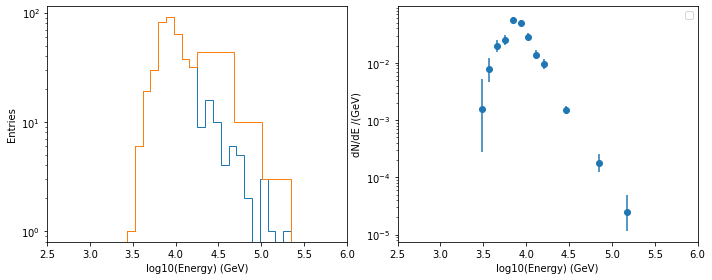

In [23]:
#https://docs.astropy.org/en/stable/api/astropy.stats.knuth_bin_width.html#astropy.stats.knuth_bin_width
plt.figure(figsize=(10, 4))
plt.subplot(121)
h0 = hist(Energy_ML, bins = 'knuth', histtype='step')

#modify bin width from 'knuth' to ensure each bin has >5 entries
adj_models = [12, 13, 12]
adj_idx = adj_models[model_name]
bin_width = (h0[1][-1]-h0[1][-adj_idx])/3

bin_append = []
for i in [1,2,3]:
    bin_append.append(h0[1][-adj_idx] + i*bin_width)
bin_append = np.array(bin_append)

bins = h0[1][:-adj_idx]
bins_new = np.append(bins, bin_append)

h0 = hist(Energy_ML, bins = bins_new, histtype='step')

plt.yscale('log')
plt.xlim(2.5, 6)
plt.xlabel('log10(Energy) (GeV)')
plt.ylabel('Entries')  
plt.tight_layout()

x0 = []
for i in range(1, len(h0[1])):
    x0.append( (h0[1][i] + h0[1][i-1])/2 ) #bin center in log10(GeV)
x0 = np.array(x0)

dE = []
for j in range(1, len(h0[1])):
    dE.append(10**h0[1][j] - 10**h0[1][j-1]) #bin size in GeV
dE = np.array(dE)

y0 = h0[0]/dE
#Error calculation
#https://docs.astropy.org/en/stable/api/astropy.stats.poisson_conf_interval.html
from astropy import stats

y0_lo_err0 = y0 - (stats.poisson_conf_interval(h0[0], interval='frequentist-confidence'))[0]/dE
y0_up_err0 = (stats.poisson_conf_interval(h0[0], interval='frequentist-confidence'))[1]/dE - y0
y0_up_err1 = (stats.poisson_conf_interval(h0[0], interval='frequentist-confidence',sigma=2))[1]/dE - y0

plt.subplot(122)

zero_data = np.logical_not(y0.astype('bool')) #data points with zero entries
zero_idx = np.where(zero_data==True)[0]
x_zero_data = x0[zero_idx]
y_zero_data = y0_up_err1[zero_idx]
uplims = np.array([1 for _ in range(len(zero_idx))], dtype=bool)

idx = np.where(y0.astype('bool')==True)[0] #data points with non-zero entries

plt.errorbar(x0[idx], y0[idx], yerr = [y0_lo_err0[idx], y0_up_err0[idx]], marker='o', linestyle='')
#plt.errorbar(x_zero_data, y_zero_data, yerr = y_zero_data/1.5, uplims=uplims, marker=7,linestyle='')

plt.yscale('log')
plt.xlim(2.5, 6)
#plt.ylim(1e-6, 1)
plt.tight_layout()
plt.legend()

plt.xlabel('log10(Energy) (GeV)')
plt.ylabel('dN/dE /(GeV)') 

In [15]:
Energy_ML[np.where(Energy_ML>5)[0]]

array([5.3451242, 5.0355425, 5.0740376], dtype=float32)

Text(0.5, 1.0, 'Fe flux')

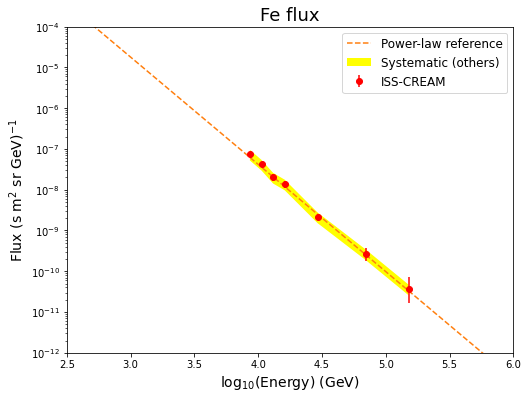

In [30]:
x = x0

A0 = 0.364358
A1 = 3.29957
A2 = 0.135761
G = A0*(1 - np.exp(-(x-A1)/A2))*np.heaviside(x-A1, 0)

#t = 13996800
t = 6938784
#e = 0.32*0.40
B0 = 0.60986744
B1 = 3.30849844
B2 = 0.11200669
e_cut = B0*(1 - np.exp(-(x-B1)/B2))*np.heaviside(x-B1, 0)
e = 0.45*e_cut # 8-120 + charge selection (24.5 < Z of SCD0 < 28)

y = y0/(e*G*t)

#Don't propagate systematic error to statistical error!!
e_err = 0.2*e
G_err = 0.15*0.35
t_err = 0.15*t
#y_err_up = abs(y)*np.sqrt( (y0_up_err0/y0)**2 + (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )
#y_err_lo = abs(y)*np.sqrt( (y0_lo_err0/y0)**2 + (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )

y_err_up = y0_up_err0/(e*G*t)
y_err_lo = y0_lo_err0/(e*G*t)


#plot data
plt.figure(figsize=(8,6))

start_model = [7, 8 ,5]
start_idx = start_model[model_name]

#plot reference power law
phi0 = 1.78*1e-2
E = np.logspace(2,6) #in GeV
a = 2.63
phi = 1e-3*phi0*(E/1e3)**(-a)
plt.plot(np.log10(E), phi, linestyle='dashed', color='C1',label='Power-law reference')

#reference experiments
#calet = Table.read('/Volumes/Others/backup/ML_regression_new/Fe_flux_compare/CALET_iron_2021.dat', format='ascii')
#ams = Table.read('/Volumes/Others/backup/ML_regression_new/Fe_flux_compare/table-si.csv', format='ascii')
#cream = Table.read('/Volumes/Others/backup/ML_regression_new/Fe_flux_compare/cream_ii.txt', format='ascii')

#CALET
#calet_E = (calet['col1']+calet['col2'])/2
#plt.errorbar( np.log10(calet_E)+np.log10(56), calet['col3']/56, 
#              yerr=calet['col4']/56, ls='none', color='b', marker='P', label='CALET')
#CREAM-II
#cream_E = cream['Kinetic_Energy_(GeV/n)']
#plt.errorbar( np.log10(cream_E)+np.log10(56), cream['Intensity_(m2_sr_s_GeV/n)-1']/56,
#              yerr=[cream['lo_error']/56, cream['up_error']/56], 
#              ls='none', color='g', marker='s', label='CREAM-II')
#AMS
#ams_R = (ams['rigidity_max GV'] + ams['rigidity_min GV'])/2
#ams_E = ams_R*26

#plt.errorbar( np.log10(ams_E), ams['iron_flux m^-2sr^-1s^-1GV^-1']/26,
#              yerr=ams['iron_flux_error_statistical m^-2sr^-1s^-1GV^-1']/26, 
#              ls='none',color='c', marker='*',label='AMS-02')


#ISS-CREAM
plt.errorbar(x0[start_idx:], y[start_idx:], \
             yerr=[y_err_lo[start_idx:], y_err_up[start_idx:]], \
             marker='o', linestyle='',color='red', label='ISS-CREAM')
#plt.errorbar(x_zero_data, y_zero_data/(0.61*0.35*t), \
#             yerr = y_zero_data/(0.61*0.35*t)/1.5, uplims=uplims, marker=7,linestyle='',color='red',)
'''
#plot systematic upper error due to energy scale (x2, or x12)
systematic1_up_x, systematic1_up_y = np.load('./Fe_Flux/result/systematic_up.npy', allow_pickle=True)
x1, x2 = x0[start_idx:], systematic1_up_x
y1, y2 = y[start_idx:], systematic1_up_y
plt.fill(np.append(x1, x2[::-1]), np.append(y1, y2[::-1]), 'aquamarine', label='Systematic (E calibration)')

#plot systematic lower error due to energy scale (x0.5, or x3)
x5, x6 = x0[start_idx-1:]-0.14, x0[start_idx:]
flux_lower_factor = np.random.random_sample(len(y[start_idx-1:],))*(1.4-1.3)+1.3
y5, y6 = y[start_idx-1:]/flux_lower_factor, y[start_idx:]
plt.fill(np.append(x5, x6[::-1]), np.append(y5, y6[::-1]), 'aquamarine')

'''
#plot systematic error due to livetime and GF
systematic2_y = abs(y)*np.sqrt( (e_err/e)**2 + (G_err/0.35)**2 + (t_err/t)**2 )
x3 = x0[start_idx:]
y3, y4 = y[start_idx:] - systematic2_y[start_idx:], y[start_idx:] + systematic2_y[start_idx:]
plt.fill(np.append(x3, x3[::-1]), np.append(y3, y4[::-1]), 'yellow', label='Systematic (others)')


#plot fitted line
#plt.plot(np.log10(E)[fit_idx], fit_func(E[fit_idx], best_pars[0], best_pars[1]), \
#         color = 'black', label='Power-law fit') 


plt.yscale('log')
plt.xlim(2.5, 6)
plt.ylim(1e-12, 1e-4)
plt.legend(fontsize=12)
plt.xlabel(r'$\rm log_{10}$(Energy) (GeV)',fontsize=14)
plt.ylabel(r'Flux $(\rm s\ m^2\ sr\ GeV)^{-1}$',fontsize=14)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.title('Fe flux',fontsize=18)

In [14]:
x0[start_idx:-2]

array([3.93442661, 4.02543936, 4.11645211, 4.20746487, 4.42362015,
       4.71941159])

In [15]:
np.log10(E)

array([2.        , 2.08163265, 2.16326531, 2.24489796, 2.32653061,
       2.40816327, 2.48979592, 2.57142857, 2.65306122, 2.73469388,
       2.81632653, 2.89795918, 2.97959184, 3.06122449, 3.14285714,
       3.2244898 , 3.30612245, 3.3877551 , 3.46938776, 3.55102041,
       3.63265306, 3.71428571, 3.79591837, 3.87755102, 3.95918367,
       4.04081633, 4.12244898, 4.20408163, 4.28571429, 4.36734694,
       4.44897959, 4.53061224, 4.6122449 , 4.69387755, 4.7755102 ,
       4.85714286, 4.93877551, 5.02040816, 5.10204082, 5.18367347,
       5.26530612, 5.34693878, 5.42857143, 5.51020408, 5.59183673,
       5.67346939, 5.75510204, 5.83673469, 5.91836735, 6.        ])

In [32]:
np.save('./Fe_Flux/result/x2_PL_fit.npy', [best_pars[0], best_pars[1]])

Phi0= 0.03301950967592705 alpha= 2.8443250942871816 Phi0_err= 0.011542825509829359 alpha_err= 0.13350102896103505


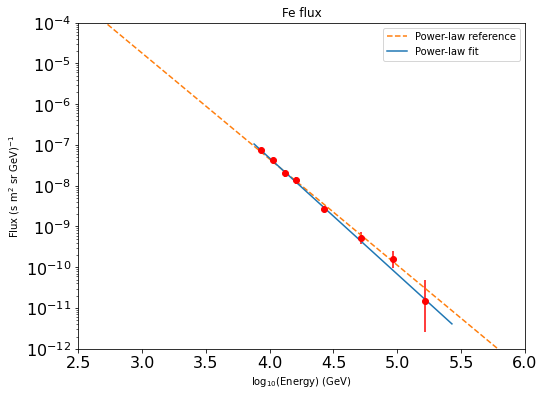

In [30]:
# Define the fit function
def fit_func(x, Phi0, alpha):
    return 1e-3*Phi0*(x/1e3)**(-alpha)

# Fit the function to data
from scipy.optimize import curve_fit

err = (y_err_up + y_err_lo)/2
best_pars, covss = curve_fit(fit_func, 10**x0[start_idx:], y[start_idx:],\
                             sigma=err[start_idx:], absolute_sigma=True)

plt.figure(figsize=(8,6))

#plot reference power law
phi0 = 1.78*1e-2
E = np.logspace(2,6) #in GeV
a = 2.6
phi = 1e-3*phi0*(E/1e3)**(-a)

plt.plot(np.log10(E), phi, linestyle='dashed', color='C1', label='Power-law reference')

plt.errorbar(x0[start_idx:], y[start_idx:], yerr=[y_err_lo[start_idx:], y_err_up[start_idx:]], marker='o', linestyle='',color='red',)

fit_idx = np.where ((np.log10(E) > 3.85) & (np.log10(E) < 5.5 )) [0] #only cover data points
plt.plot(np.log10(E)[fit_idx], fit_func(E[fit_idx], best_pars[0], best_pars[1]), label='Power-law fit') 

plt.yscale('log')
plt.xlim(2.5, 6)
plt.ylim(1e-12, 1e-4)
plt.legend()
plt.xlabel(r'$\rm log_{10}$(Energy) (GeV)')
plt.ylabel(r'Flux $(\rm s\ m^2\ sr\ GeV)^{-1}$')
plt.title('Fe flux')

print('Phi0=',best_pars[0], 'alpha=', best_pars[1], \
      'Phi0_err=', np.sqrt(covss[0][0]),'alpha_err=',np.sqrt(covss[1][1]))

In [ ]:
systematic_up = [x0[start_idx:], y[start_idx:]]
np.save('./Fe_Flux/result/systematic_up.npy', systematic_up)

In [18]:
#print energy bin and flux
for j in range(len(y[start_idx:])):
    y_sn = "{:.2e}".format(y[start_idx:][j])
    y_err_lo_sn = "{:.2e}".format(y_err_lo[start_idx:][j])
    y_err_up_sn = "{:.2e}".format(y_err_up[start_idx:][j])

    print( 'Flux:', y_sn,'Lower:', y_err_lo_sn, 'Upper:', y_err_up_sn)

Flux: 8.97e-08 Lower: 1.36e-08 Upper: 1.59e-08
Flux: 5.61e-08 Lower: 9.58e-09 Upper: 1.14e-08
Flux: 3.22e-08 Lower: 6.53e-09 Upper: 8.01e-09
Flux: 1.88e-08 Lower: 4.52e-09 Upper: 5.77e-09
Flux: 1.29e-08 Lower: 3.41e-09 Upper: 4.45e-09
Flux: 2.46e-09 Lower: 5.90e-10 Upper: 7.52e-10
Flux: 6.30e-10 Lower: 2.50e-10 Upper: 3.76e-10
Flux: 3.10e-10 Lower: 1.34e-10 Upper: 2.10e-10
Flux: 3.67e-11 Lower: 3.03e-11 Upper: 8.43e-11


In [29]:
10**h0[1][start_idx:]

array([ 4092.97341833,  4877.34402957,  5812.03011881,  6925.83789397,
        8253.09393671,  9834.70311766, 19830.74903599, 33556.18009252,
       56781.37625354, 96081.39783359])

In [23]:
10**x0[start_idx:]

array([ 4467.97934922,  5324.21547269,  6344.53926126,  7560.39620188,
        9009.25794224, 13965.29732479, 25796.20487632, 43650.49928082,
       73862.2637167 ])